# Computing RADAR Cube

To use this script, you must have the RaDICaL dataset and its SDK. If you don't already have them, please download using the following cell

In [2]:
# !wget https://fireball.teckyianlim.me/file/flaming-cake/indoor_sample_50.h5
# !python -m pip install git+https://github.com/moodoki/radical_sdk.git

Importing required libraries

In [3]:
from radicalsdk.h5dataset import H5DatasetLoader
from radicalsdk.radar.config_v1 import read_radar_params
from radicalsdk.radar.v1 import RadarFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import gaussian_filter

2025-05-12 16:10:00.922234: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 16:10:01.943740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-12 16:10:01.952640: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 16:10:04.449061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Loading data

Load data configuration

In [4]:
# Load dataset
data = H5DatasetLoader('indoor_sample_50.h5')
frame_idx = 1 # Select frame to visualize

# Load radar config
CONFIG_PATH = 'radarcfg/indoor_human_rcs.cfg'
radar_config = read_radar_params(CONFIG_PATH)
print(radar_config) # print RADAR config on command line

with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])

{'numLanes': 4, 'rx4': True, 'rx3': True, 'rx2': True, 'rx1': True, 'numTx': 2, 'tx3': True, 'tx2': False, 'tx1': True, 'isComplex': True, 'image_band': False, 'profiles': [{'id': 0, 'start_frequency': 77000000000.0, 'idle': 5.8e-05, 'adcStartTime': 7e-06, 'rampEndTime': 3.9999999999999996e-05, 'txPower': 0.0, 'txPhaseShift': 0.0, 'freqSlopeConst': 100000000000000.0, 'txStartTime': 1e-06, 'adcSamples': 304, 'adcSampleRate': 9499000.0, 'hpfCornerFreq1': 0, 'hpfCornerFreq2': 0, 'rxGain': 30.0}], 'chirps': [{'chirpStartIndex': 0, 'chirpStopIndex': 0, 'profileID': 0, 'startFreqVariation': 0.0, 'slopeVariation': 0.0, 'idleVariation': 0.0, 'adcStartVariation': 0.0, 'chirptx3': False, 'chirptx2': False, 'chirptx1': True}, {'chirpStartIndex': 1, 'chirpStopIndex': 1, 'profileID': 0, 'startFreqVariation': 0.0, 'slopeVariation': 0.0, 'idleVariation': 0.0, 'adcStartVariation': 0.0, 'chirptx3': True, 'chirptx2': False, 'chirptx1': False}], 'numChirps': 64, 'fps': 30.00030000300003, 'adcPower': 'reg

Load current frame

In [5]:
current_radar_frame = data['radar'][frame_idx]
rf = RadarFrame(radar_config)
print(current_radar_frame.shape)

(32, 8, 304)


If this gives you an error that complex is not defined in numpy, please change in line 529 of ~/.local/lib/python3.8/site-packages/mmwave/dsp/angle_estimation.py:
`np.complex` $\rightarrow$ `complex`

As we have shape (32, 8, 304), this means that it corresponds to bins (chirps, antennas, samples).

These will be used to compute, in this order:

1. **Sample** → **Range**
2. **Chirp** → **Doppler**
3. **Antenna** → **Angle**

We are assessing the frame with the following picture from the camera:

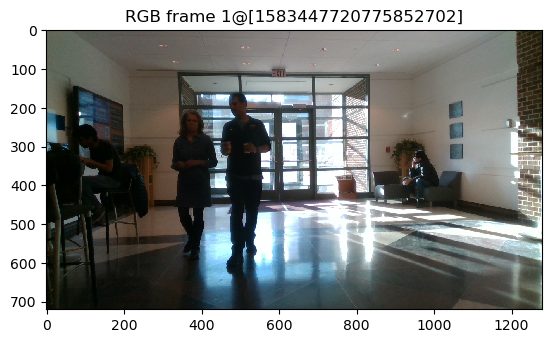

In [6]:
plt.figure()
plt.imshow(data['rgb'][frame_idx][..., ::-1])
plt.title(f'RGB frame {frame_idx}@{data["rgb_timestamp"][frame_idx]}')
plt.show()

## 2. Computing resolutions to determine units

Computing range units

In [7]:
# speed of wave propagation
c = 299792458 # m/s
# compute ADC sample period T_c in msec
adc_sample_period = 1 / adc_sample_rate * num_adc_samples # msec
# next compute the Bandwidth in GHz
bandwidth = adc_sample_period * chirp_slope # GHz
# Coompute range resolution in meters
range_resolution = c / (2 * (bandwidth * 1e9)) # meters
# Compute max range
max_range = range_resolution * num_adc_samples

# Calculate change in range data labels
ranges = np.arange(0, max_range + range_resolution, range_resolution)
range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

Computing doppler units

In [8]:
# extract number of chirps
num_chirps = current_radar_frame.shape[0]
# compute center frequency in GHz
center_freq = (77 + bandwidth/2) # GHz
# compute center wavelength 
lmbda = c/(center_freq * 1e9) # meters
# interval for an entire chirp including deadtime
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec
# compute doppler resolution
doppler_resolution = lmbda / (2 * num_chirps * num_tx * chirp_interval)
# compute max doppler reading
max_doppler = num_chirps * doppler_resolution / 2 # m/s

# Calculate change in doppler data labels
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
doppler_tick_labels = dopplers[::len(dopplers)//10][::-1].round(2)


Computing angle units

## 3. Computing RADAR cube with FFTs

### a. Correct computation

Computing FFTs with shift in doppler and angle dimensions

In [9]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

# Angle FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

radar_cube = azimuth_fft

### b. Alternatives

Computing FFTs with shift in the angle dimension only

In [10]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fft(range_fft, axis=0)

# Angle FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

radar_cube_no_doppler_shift = azimuth_fft

Computing FFTs only in range and doppler dimensions

In [11]:
# Range FFT
range_fft = np.fft.fft(current_radar_frame, axis=2)

# Doppler FFT
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

radar_cube_no_azimuth_fft = doppler_fft

## 4. Visualizations experiments

### a. Visualizing the effect of using fftshift on the doppler fft 

The data originally at 0 →-> data at 16 (and equivalently for the rest of the cube, meaning that all of the data gets shifted by 16 in the doppler axis)

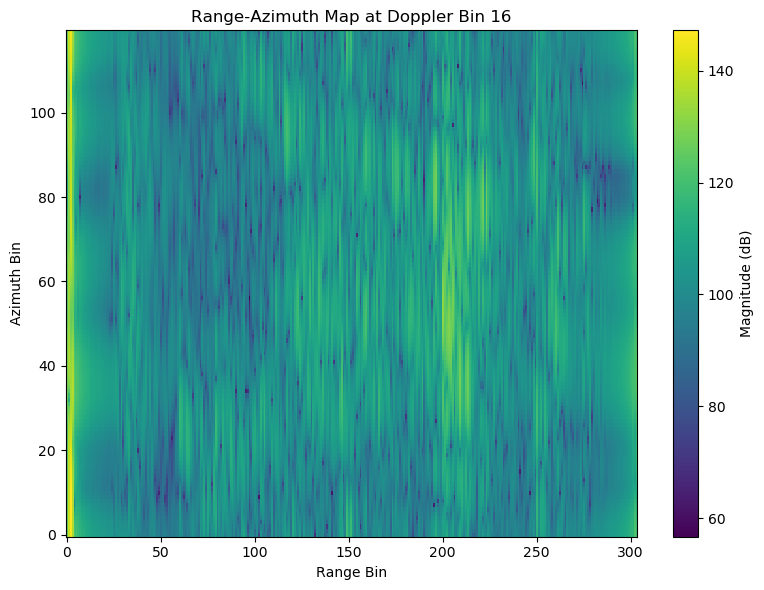

In [12]:
doppler_bin = 16  # Pick any valid dop bin

# Get a 2D slice: Azimuth vs Range at this doppler bin
slice_data = radar_cube[doppler_bin, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(20 * np.log10(np.abs(slice_data)),
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Azimuth Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()


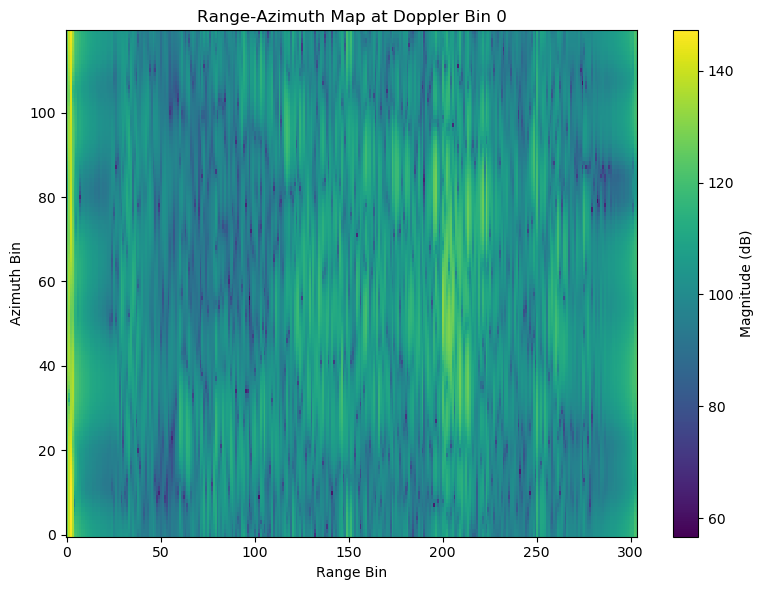

In [13]:
doppler_bin = 0  # Pick any valid doppler bin

# Get a 2D slice: Azimuth vs Range at this doppler bin
slice_data = radar_cube_no_doppler_shift[doppler_bin, :, :]

plt.figure(figsize=(8, 6))
plt.imshow(20 * np.log10(np.abs(slice_data)),
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Azimuth Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

As we have negative and positive velocities, we do indeed want the zero bin to be in the middle

### b. Visualizing effect of summing vs. taking the mean over the dimensions being collapsed

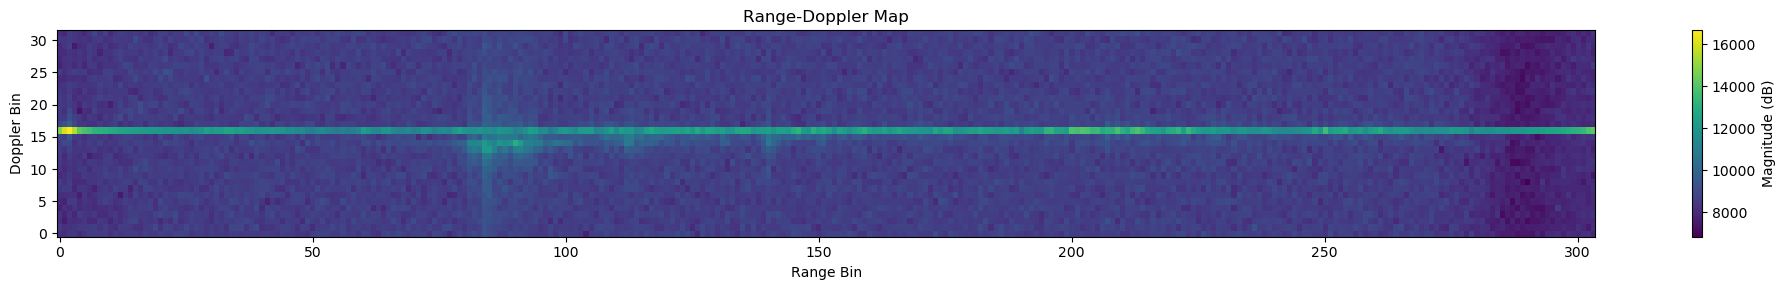

In [14]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.sum(20 * np.log10(np.abs(radar_cube)), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Doppler Map')
plt.tight_layout()
plt.show()

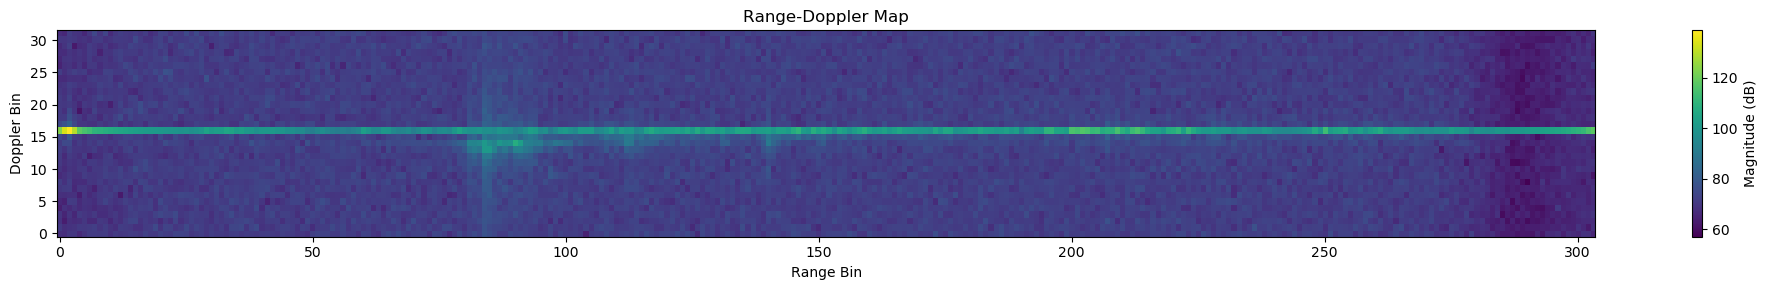

In [15]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.mean(20 * np.log10(np.abs(radar_cube)), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Doppler Map')
plt.tight_layout()
plt.show()

range, diazimuth and doppler values being correct for our cube cropping, the actual magnitude of the intneeonly about range, azimuth and doppler values being correct for our cube cropping,  actualis not of much importance.

It also doesn't really matter whether you take the sum or mean over the azimuth dimensions with or without FFT. The ones above are with FFT over that dimensions, and the one below without:

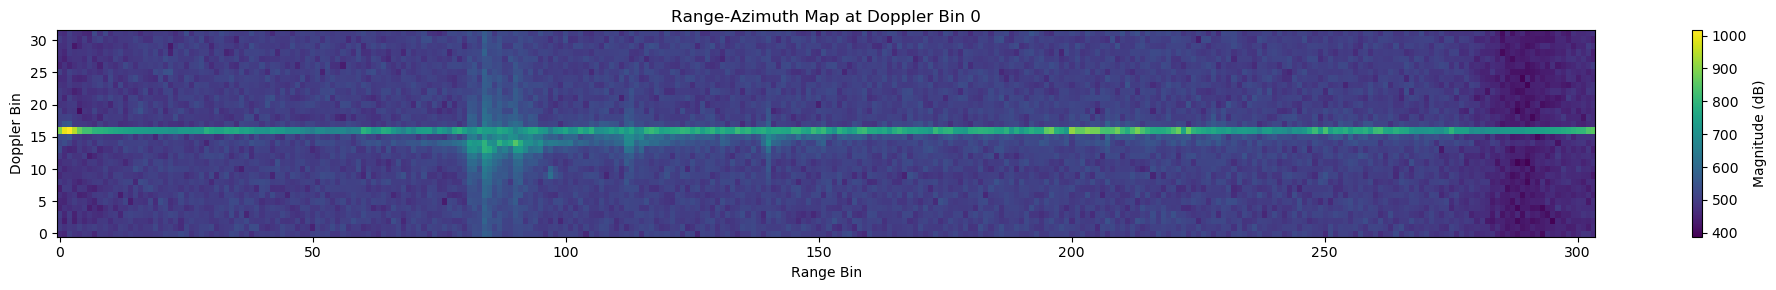

In [16]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.sum(10 * np.log10(np.abs(radar_cube_no_azimuth_fft)**2), axis=1)  # Sum over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(collapsed_range_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title(f'Range-Azimuth Map at Doppler Bin {doppler_bin}')
plt.tight_layout()
plt.show()

Once again, only the magnitues change significantly. However, you do still see some higher intensities for a few parts, but things remain mostly the same.

### c. Full RADAR cube

Now, we visualize the full radar cube

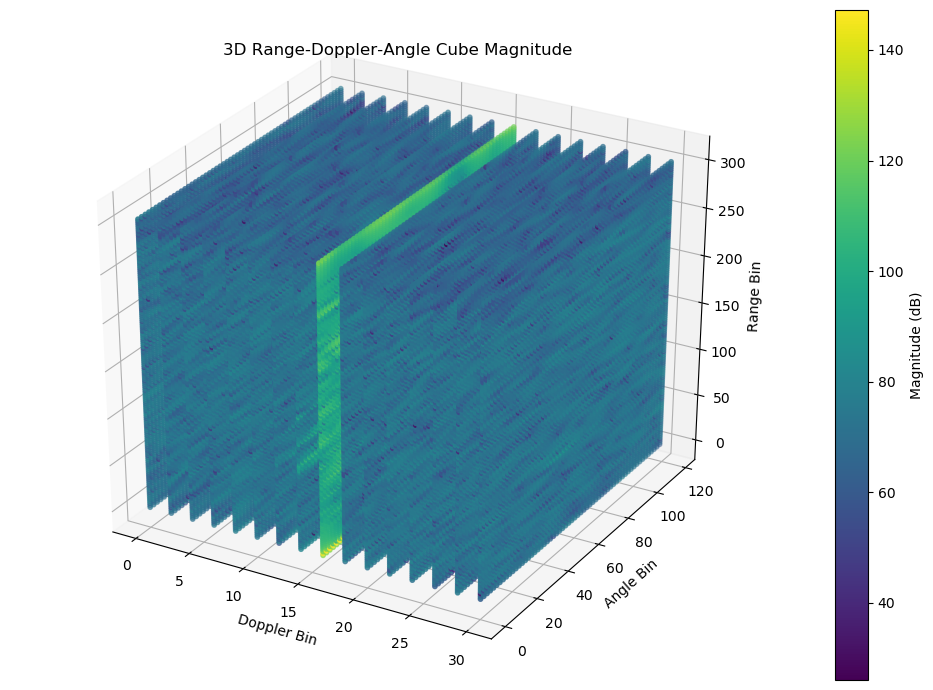

In [17]:
doppler_bins, angle_bins, range_bins = radar_cube.shape

# We'll downsample the data to avoid overcrowding the plot (optional)
downsample = 2
R, D, A = np.meshgrid(np.arange(0, doppler_bins, downsample),
                      np.arange(0, angle_bins, downsample),
                      np.arange(0, range_bins, downsample),
                      indexing='ij')

# Get the magnitude in dB
magnitude = 20 * np.log10(np.abs(radar_cube[::downsample, ::downsample, ::downsample]) + 1e-6)

# Flatten for scatter plotting
R_flat = R.flatten()
D_flat = D.flatten()
A_flat = A.flatten()
mag_flat = magnitude.flatten()

# Plot only points above a magnitude threshold to avoid clutter
threshold_dB = -40  # You can adjust this for clearer plots
mask = mag_flat > threshold_dB

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(R_flat[mask], D_flat[mask], A_flat[mask],
               c=mag_flat[mask], cmap='viridis', s=10)

ax.set_xlabel('Doppler Bin')
ax.set_ylabel('Angle Bin')
ax.set_zlabel('Range Bin')
fig.colorbar(p, label='Magnitude (dB)')
plt.title('3D Range-Doppler-Angle Cube Magnitude')
plt.tight_layout()
plt.show()

## 5. Estimating velocities on the full domain

Visualize radar cube data collapsed over the doppler dimension (as the velocity will come from the doppler dimension)

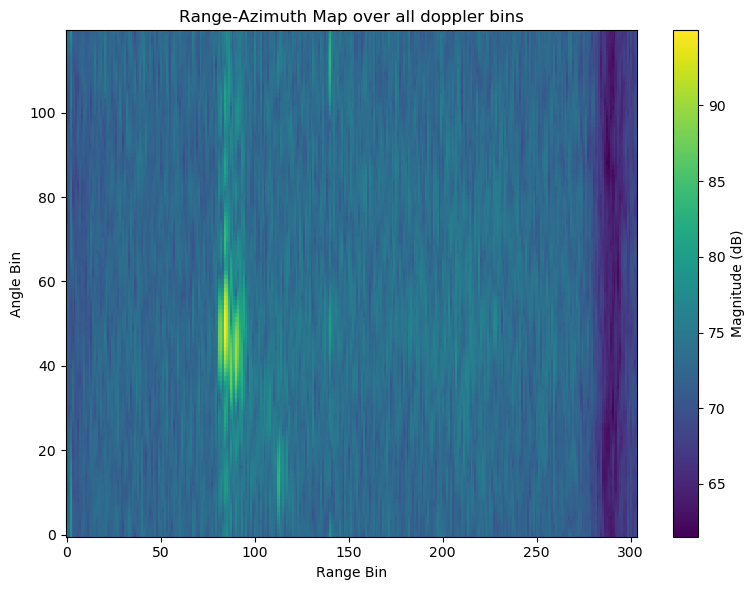

In [18]:
# Collapse data into a 2D slice, collapsing over the doppler dimension
collapsed_doppler = np.mean(20 * np.log10(np.abs(radar_cube)), axis=0)  # Sum over doppler dimension

plt.figure(figsize=(8, 6))
plt.imshow(collapsed_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')
plt.title(f'Range-Azimuth Map over all doppler bins')
plt.tight_layout()
plt.show()

### a. Index of maximum intensity reading in doppler axis

What is visualized above is the intensities of the average reflectiveness of objects across all velocities, and not the velocities themselves. To compute the velocities, one approach is to take the index of the maximum intensity reading in the doppler axis.

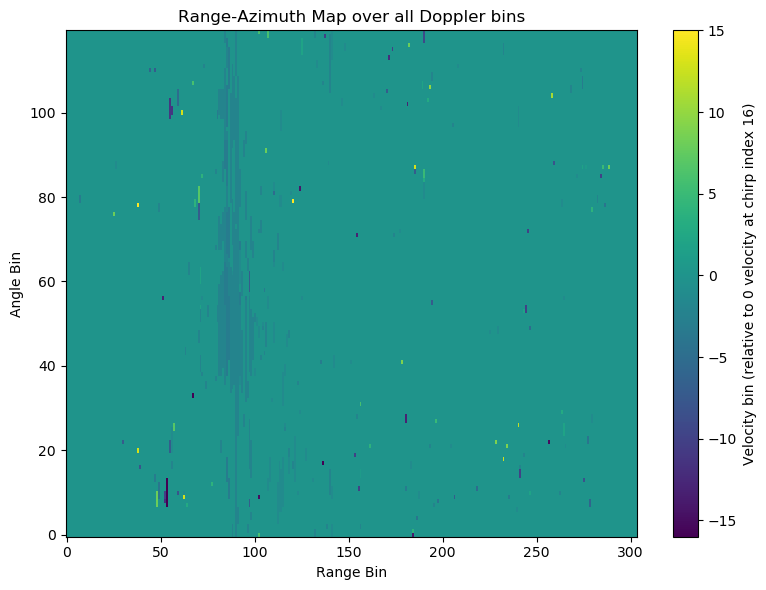

In [19]:
# Collapse data into a 2D slice by taking the index of the max magnitude over the Doppler dimension
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)

# Shift indices: index 16 -> 0 velocity, below -> negative, above -> positive
velocity_bins = collapsed_doppler - 16

plt.figure(figsize=(8, 6))
plt.imshow(velocity_bins, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Velocity bin (relative to 0 velocity at chirp index 16)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')
plt.title('Range-Azimuth Map over all Doppler bins')
plt.tight_layout()
plt.show()

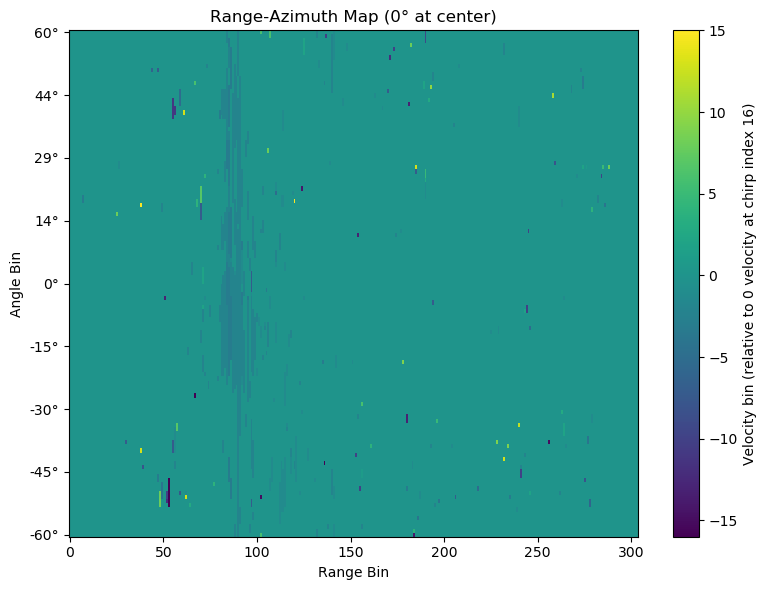

In [20]:
# Collapse data into a 2D slice by taking the index of the max magnitude over the Doppler dimension
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)

# Shift indices: index 16 -> 0 velocity, below -> negative, above -> positive
velocity_bins = collapsed_doppler - 16

plt.figure(figsize=(8, 6))
plt.imshow(velocity_bins, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Velocity bin (relative to 0 velocity at chirp index 16)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Range-Azimuth Map (0° at center)')
plt.tight_layout()
plt.show()

Now adding correct units yields

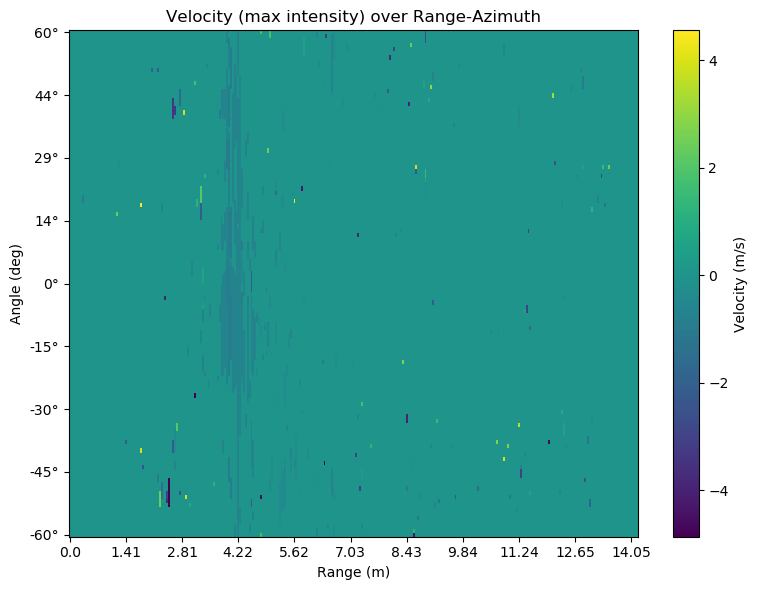

In [21]:
# Collapse to bin indices
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Testing with velocities = 0

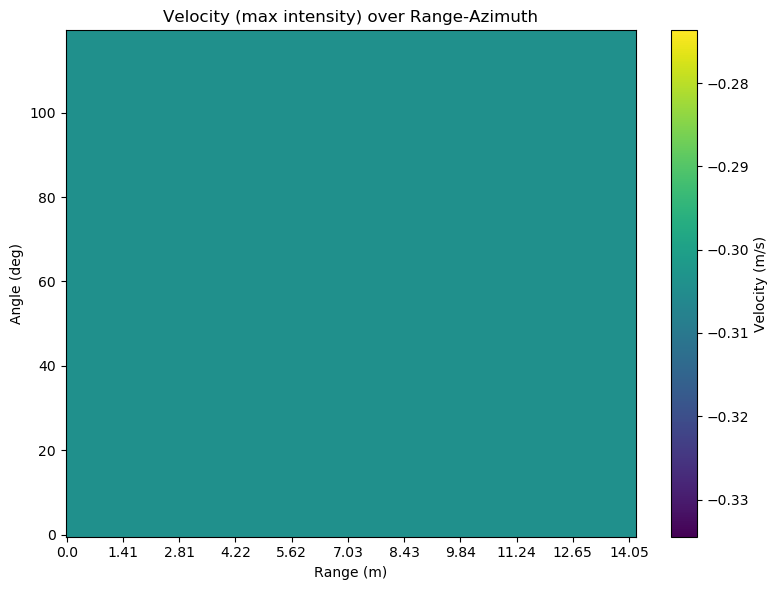

In [22]:
# Collapse to bin indices
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
collapsed_doppler = np.ones_like(collapsed_doppler)*15

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Testing with velocities = max

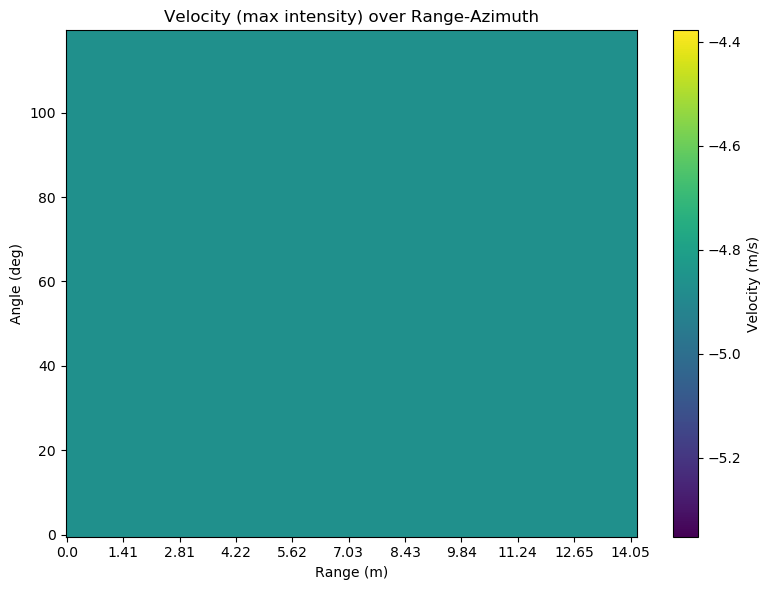

In [23]:
# Collapse to bin indices
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
collapsed_doppler = np.zeros_like(collapsed_doppler)

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Gaussian Filtering on velocity data to remove high frequency noise

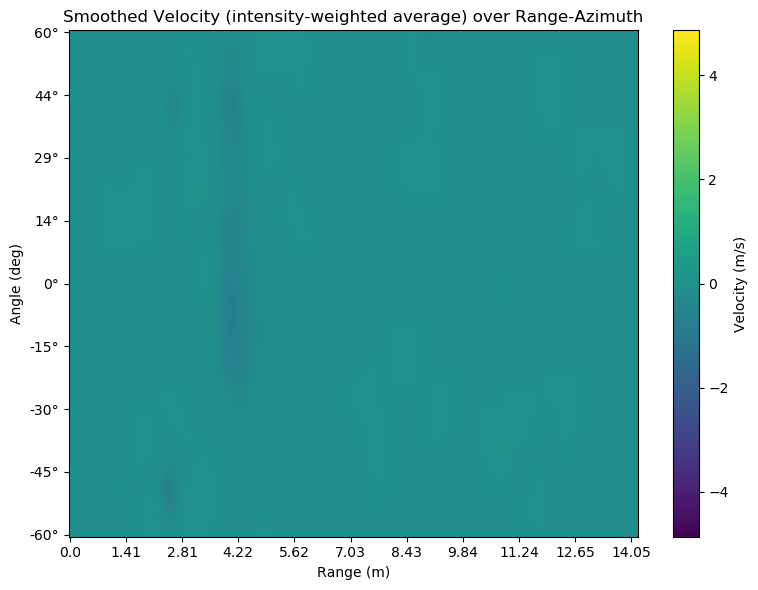

In [24]:
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Apply Gaussian smoothing ----

sigma = 3  # Smoothing strength — increase for more smoothing
smoothed_velocity = gaussian_filter(collapsed_doppler_velocity, sigma=sigma, radius=3*sigma)

# ---- Prepare angle labels ----

angle_bins = radar_cube.shape[1]  # Angle dimension
angles = np.linspace(-60, 60, angle_bins)  # Assuming ±60° FOV over angle_bins

num_ticks = 9  # Number of angle tick marks
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]

# ---- Plot the smoothed velocity map ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity, aspect='auto', origin='lower', cmap='viridis', vmin=-max_doppler,
                vmax=+max_doppler)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.yticks(tick_positions, tick_labels)

plt.title('Smoothed Velocity (intensity-weighted average) over Range-Azimuth')
plt.tight_layout()
plt.show()


Plotted again but without fixing the axis for better visualization

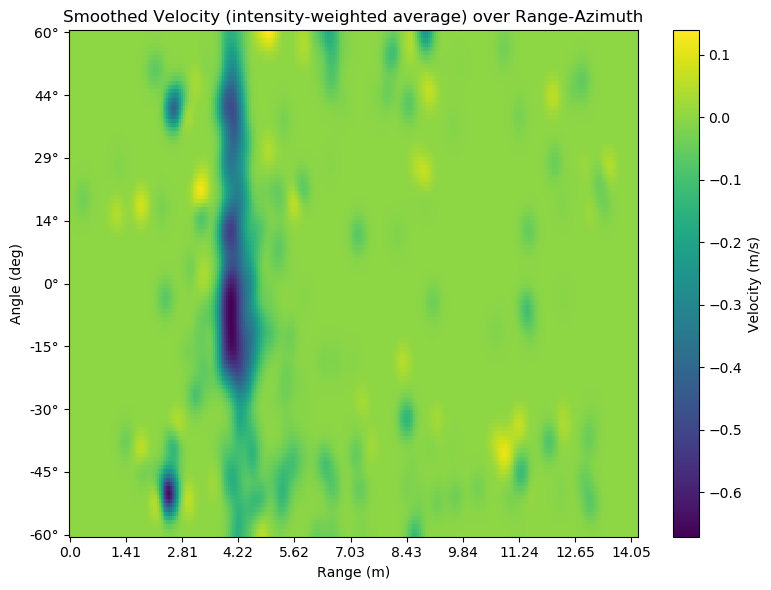

In [25]:
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Apply Gaussian smoothing ----

sigma = 3  # Smoothing strength — increase for more smoothing
smoothed_velocity = gaussian_filter(collapsed_doppler_velocity, sigma=sigma, radius=3*sigma)

# ---- Prepare angle labels ----

angle_bins = radar_cube.shape[1]  # Angle dimension
angles = np.linspace(-60, 60, angle_bins)  # Assuming ±60° FOV over angle_bins

num_ticks = 9  # Number of angle tick marks
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]

# ---- Plot the smoothed velocity map ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.yticks(tick_positions, tick_labels)

plt.title('Smoothed Velocity (intensity-weighted average) over Range-Azimuth')
plt.tight_layout()
plt.show()

We apply a non-square gaussian filter to emphasize the angular axis (where things are stretched)

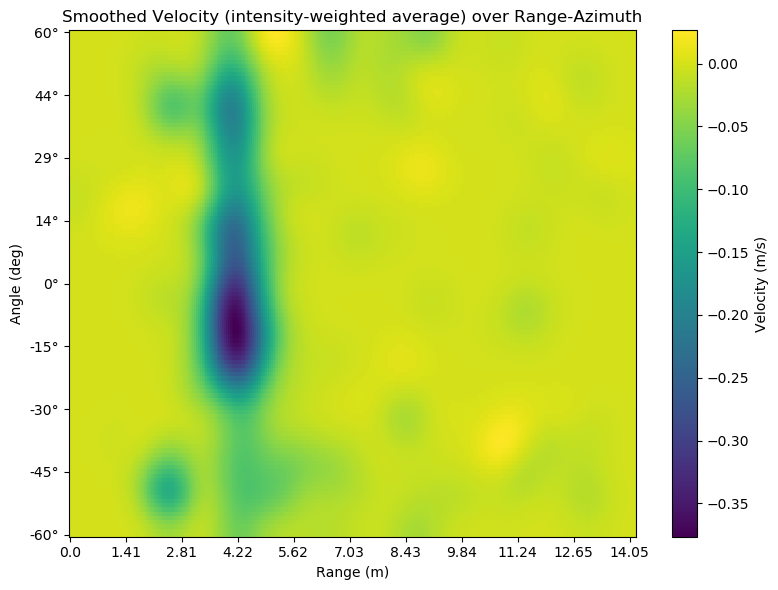

In [26]:
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Apply Gaussian smoothing ----

sigma_range = 10  # Smoothing strength — increase for more smoothing
sigma_azimuth = 5
smoothed_velocity = gaussian_filter(collapsed_doppler_velocity, sigma=(sigma_azimuth, sigma_range), radius=(sigma_azimuth*3, sigma_range*3))

# ---- Prepare angle labels ----

angle_bins = radar_cube.shape[1]  # Angle dimension
angles = np.linspace(-60, 60, angle_bins)  # Assuming ±60° FOV over angle_bins

num_ticks = 9  # Number of angle tick marks
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]

# ---- Plot the smoothed velocity map ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity, aspect='auto', origin='lower', cmap='viridis',
               # vmin=-max_doppler,
                # vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.yticks(tick_positions, tick_labels)

plt.title('Smoothed Velocity (intensity-weighted average) over Range-Azimuth')
plt.tight_layout()
plt.show()

Applying median filter instead to get rid of salt and pepper noise 

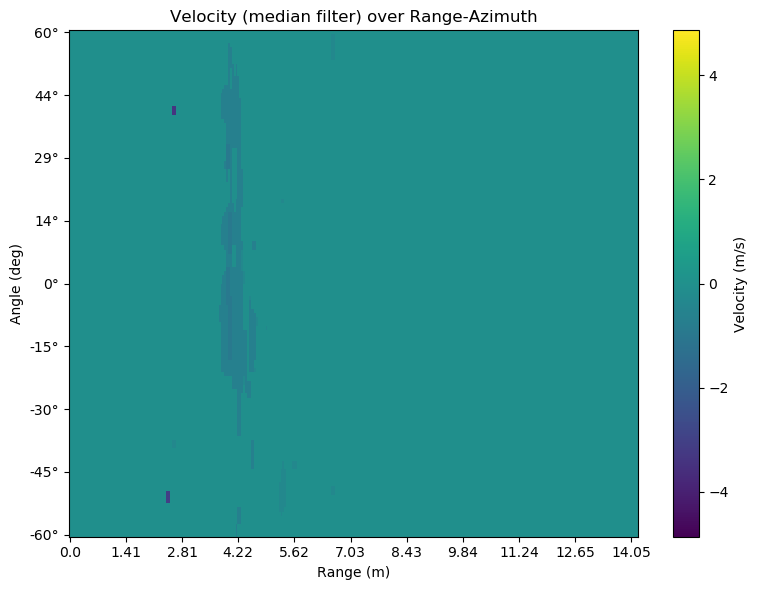

In [27]:
from scipy.ndimage import median_filter

collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Apply Median Filter ----

sigma = 3  # Smoothing strength — increase for more smoothing
smoothed_velocity = median_filter(collapsed_doppler_velocity, sigma)

# ---- Prepare angle labels ----

angle_bins = radar_cube.shape[1]  # Angle dimension
angles = np.linspace(-60, 60, angle_bins)  # Assuming ±60° FOV over angle_bins

num_ticks = 9  # Number of angle tick marks
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]

# ---- Plot the smoothed velocity map ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity, aspect='auto', origin='lower', cmap='viridis',
               vmin=-max_doppler,
                vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (median filter) over Range-Azimuth')
plt.tight_layout()
plt.show()

Works super well!

We try to threshold data by intensity as well, but this doesn't work so well

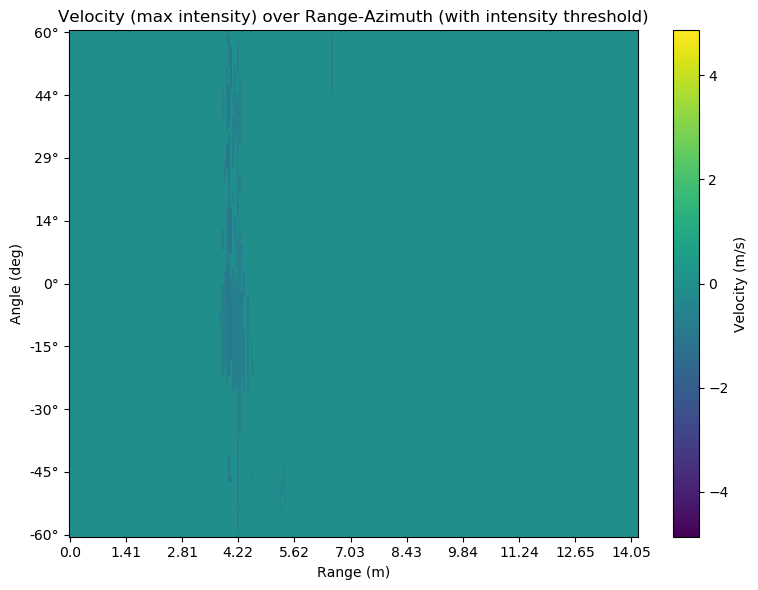

In [98]:
# Collapse to bin indices (max magnitude Doppler bin per angle-range cell)
collapsed_doppler = np.argmax(np.abs(radar_cube), axis=0)

# Total intensity at each (angle, range) bin (for thresholding)
total_intensity = np.sum(np.abs(radar_cube), axis=0)

# ---- Apply intensity threshold ----

# Threshold value in dB
min_intensity_dB = 110  # Adjust as needed
min_intensity_linear = 10**(min_intensity_dB / 20)

# Mask bins with low total intensity
collapsed_doppler[total_intensity < min_intensity_linear] = 16  # Or pick a background value like center bin

# ---- Convert bin indices to velocities ----

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Plot ----

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis',
               vmin=-max_doppler,
                vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Angle axis ticks
angle_bins = radar_cube.shape[1]
angles = np.linspace(-60, 60, angle_bins)

num_ticks = 9
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth (with intensity threshold)')
plt.tight_layout()
plt.show()


**Conclusion:** Taking the max and then applying the median filter AND/OR using intensity thresholding gives the best results!

In [123]:
from scipy.ndimage import median_filter

# Step 1: Smooth the magnitude cube (optional but helpful)
magnitude_cube = np.abs(radar_cube)

# Step 2: Collapse to max magnitude Doppler bin per angle-range cell
collapsed_doppler = np.argmax(magnitude_cube, axis=0)  # shape: [azimuth, range]
collapsed_doppler = median_filter(collapsed_doppler, size=3)  # (doppler, azimuth, range)

# Step 3: Compute total intensity at each (azimuth, range) bin for thresholding
total_intensity = np.sum(collapsed_doppler, axis=0)

# Step 4: Apply intensity threshold (suppress weak detections)
min_intensity_dB = collapsed_doppler.max() +1
min_intensity_linear = 10**(min_intensity_dB / 20)

collapsed_doppler[total_intensity < min_intensity_linear] = 16  # Set to center Doppler bin

# Step 5: Convert Doppler bin indices to velocities
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# Step 6: Plot the velocity heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(
    collapsed_doppler_velocity,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    vmin=-max_doppler,
    vmax=max_doppler
)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Y-axis: Azimuth angle ticks
angle_bins = radar_cube.shape[1]
angles = np.linspace(-60, 60, angle_bins)
num_ticks = 9
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth (Filtered + Thresholded)')
plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 120 but corresponding boolean dimension is 304

### b. Weighted average of indices in doppler axis, weighted by intensity readings

Compute velocities using weighted averaging

In [29]:
# Get magnitude over doppler axis
magnitude = np.abs(radar_cube)  # Shape: [doppler_bins, angle_bins, range_bins]

# Create an array of doppler bin indices (shape [doppler_bins, 1, 1] so it can broadcast)
doppler_indices = np.arange(magnitude.shape[0])[:, np.newaxis, np.newaxis]

# Compute weighted sum of indices
weighted_sum = np.sum(magnitude * doppler_indices, axis=0)

# Compute total intensity per range-azimuth bin
total_intensity = np.sum(magnitude, axis=0) + 1e-6  # Add epsilon to avoid divide by zero

# Weighted average index
collapsed_doppler_weighted_av = weighted_sum / total_intensity  # Shape: [angle_bins, range_bins]

Plot the velocities

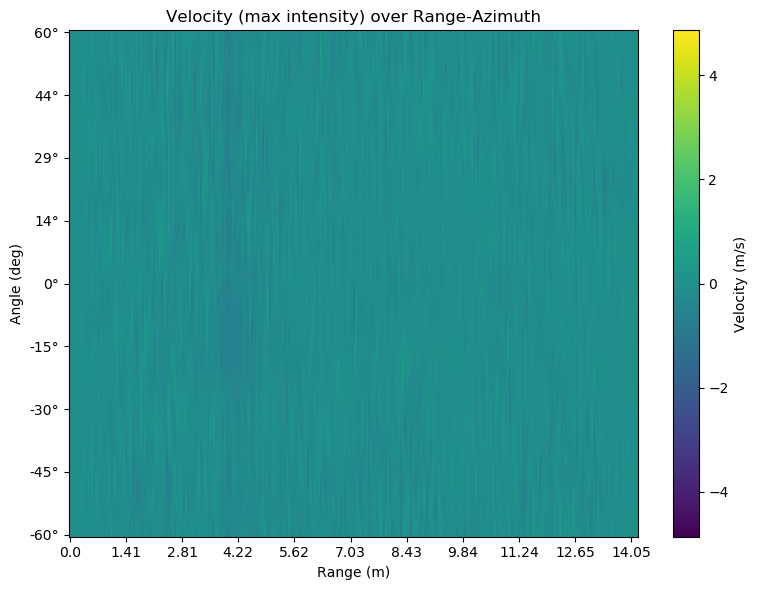

In [30]:
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Interpolate fractional indices to actual velocities
collapsed_doppler_weighted_av_velocity = np.interp(
    collapsed_doppler_weighted_av,
    np.arange(len(dopplers)),
    dopplers
)

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_weighted_av_velocity, aspect='auto', origin='lower', cmap='viridis', vmin=-max_doppler,
                vmax=+max_doppler)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

The same but without fixing the axis for better visualization

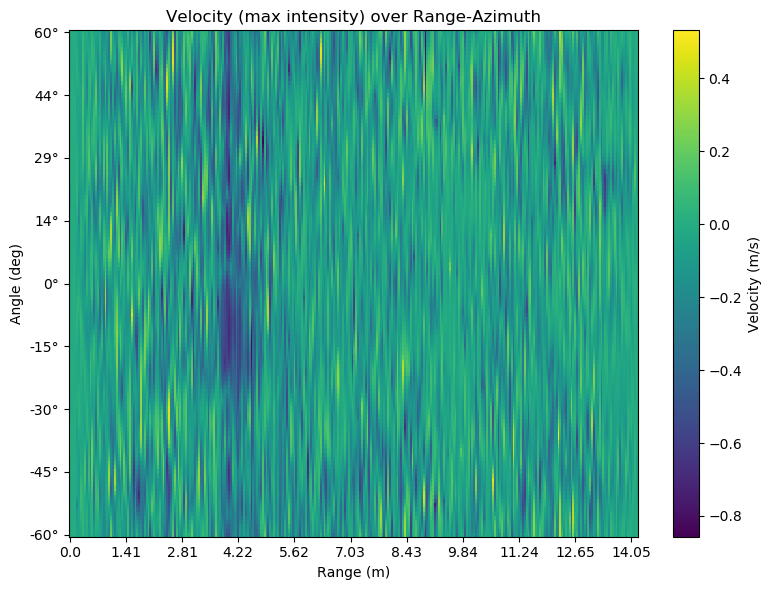

In [31]:
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Interpolate fractional indices to actual velocities
collapsed_doppler_weighted_av_velocity = np.interp(
    collapsed_doppler_weighted_av,
    np.arange(len(dopplers)),
    dopplers
)

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_weighted_av_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

We apply a gaussian filter to this

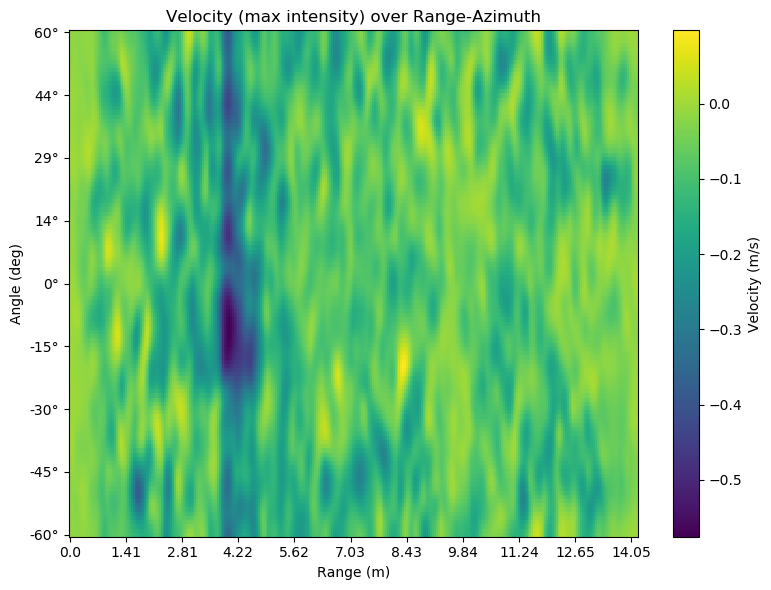

In [32]:
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Interpolate fractional indices to actual velocities
collapsed_doppler_weighted_av_velocity = np.interp(
    collapsed_doppler_weighted_av,
    np.arange(len(dopplers)),
    dopplers
)

# ---- Apply Gaussian smoothing ----

sigma_range = 2  # Smoothing strength — increase for more smoothing
sigma_azimuth = 2
smoothed_velocity_weighted_av = gaussian_filter(collapsed_doppler_weighted_av_velocity, sigma=(sigma_azimuth, sigma_range), radius=(sigma_azimuth*3, sigma_range*3))

# ---- Prepare angle labels ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity_weighted_av, aspect='auto', origin='lower', cmap='viridis',
               # vmin=-max_doppler,
               #  vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

Alternatively we use intensity thresholding again

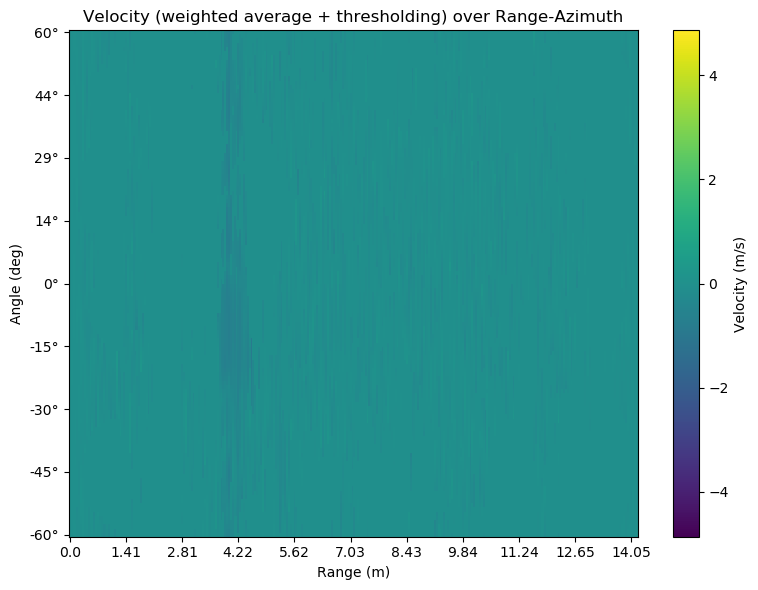

In [33]:
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Total intensity at each (angle, range) bin (for thresholding)
total_intensity = np.sum(np.abs(radar_cube), axis=0)

# ---- Apply intensity threshold ----

# Threshold value in dB
min_intensity_dB = 110  # Adjust as needed
min_intensity_linear = 10**(min_intensity_dB / 20)

# Mask bins with low total intensity
collapsed_doppler_weighted_av[total_intensity < min_intensity_linear] = 16  # Or pick a background value like center bin

# ---- Convert bin indices to velocities ----

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
# Interpolate fractional indices to actual velocities
collapsed_doppler_weighted_av_velocity = np.interp(
    collapsed_doppler_weighted_av,
    np.arange(len(dopplers)),
    dopplers
)
# --- ---

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_weighted_av_velocity, aspect='auto', origin='lower', cmap='viridis', vmin=-max_doppler,
                vmax=+max_doppler)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (weighted average + thresholding) over Range-Azimuth')
plt.tight_layout()
plt.show()

## 6. Windowing

We apply windowing to see how it affects the signal

In [147]:
# Range FFT
window = np.hanning(current_radar_frame.shape[2])
window = window[np.newaxis, np.newaxis, :]
range_fft = np.fft.fft(current_radar_frame*window, axis=2)

# Doppler FFT
window = np.hanning(current_radar_frame.shape[0])
window = window[:, np.newaxis, np.newaxis]
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft*window, axis=0), axes=0)

# Angle FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
window = np.hanning(padded_range_fft.shape[1])
window = window[np.newaxis, :, np.newaxis]
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft*window, axis=1), axes=1)

radar_cube_windowing = azimuth_fft

Figures:

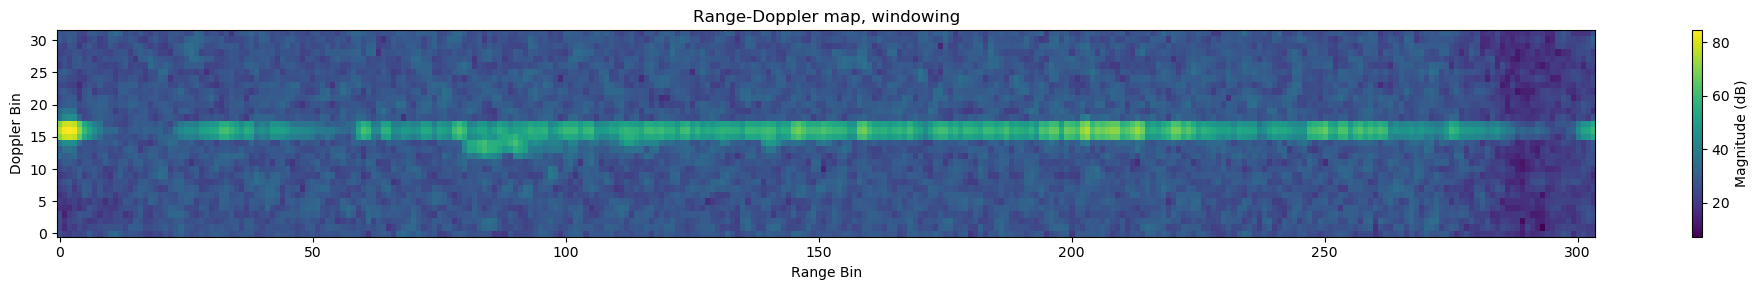

In [149]:
# Collapse data into a 2D slice, collapsing over the azimuth dimension
collapsed_range_doppler = np.mean(20 * np.log10(np.abs(radar_cube_windowing)), axis=1)  # Mean over azimuth dimension

plt.figure(figsize=(20, 3))
plt.imshow(
    collapsed_range_doppler,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    # vmin=0,   # Minimum of color scale
    # vmax=140  # Maximum of color scale
)
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title('Range-Doppler map, windowing')
plt.tight_layout()
plt.show()

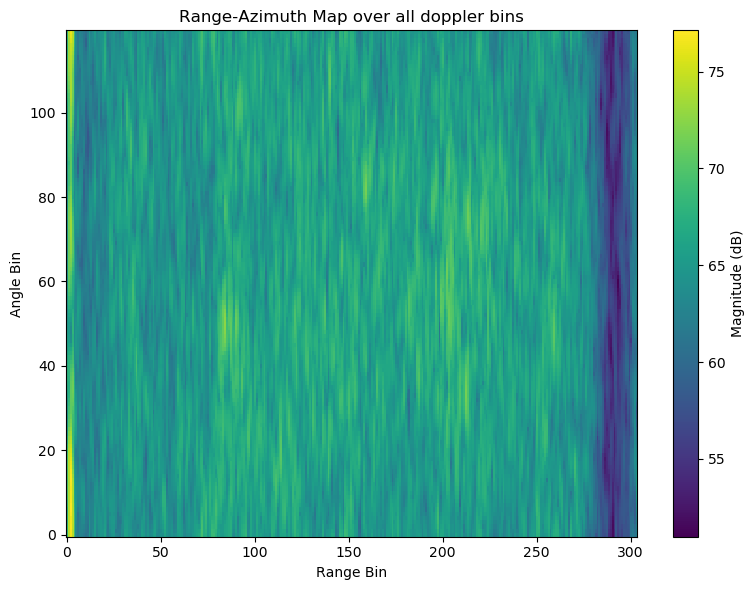

In [34]:
# Collapse data into a 2D slice, collapsing over the doppler dimension
collapsed_doppler = np.mean(20 * np.log10(np.abs(radar_cube_windowing)), axis=0)  # Sum over doppler dimension

plt.figure(figsize=(8, 6))
plt.imshow(collapsed_doppler, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Angle Bin')
plt.title(f'Range-Azimuth Map over all doppler bins')
plt.tight_layout()
plt.show()

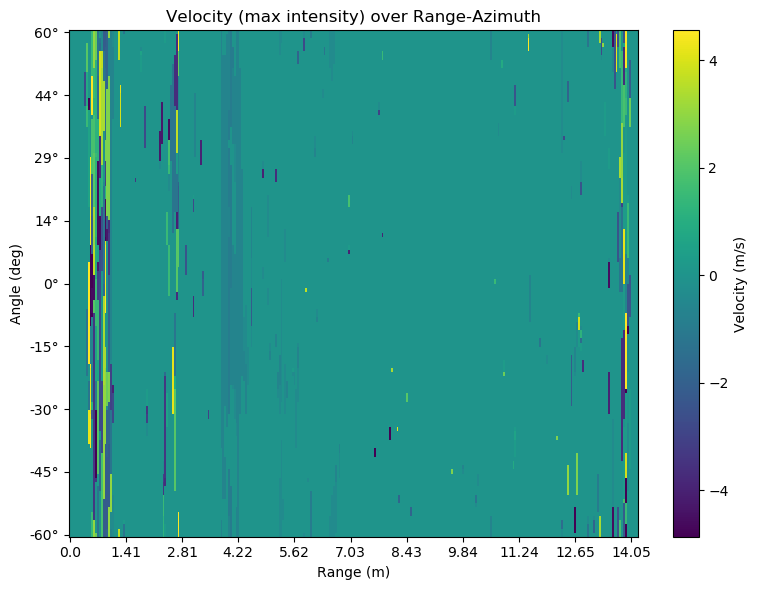

In [150]:
# Collapse to bin indices
collapsed_doppler = np.argmax(np.abs(radar_cube_windowing), axis=0)

dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis')

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar automatically uses velocity values now
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Assume angle_bins = 120 -> angles from -60 to +60 degrees
angle_bins = radar_cube.shape[1]  # (Double-check this matches your dimension)
angles = np.linspace(-60, 60, angle_bins)

# Update y-axis ticks to show actual azimuth angles
num_ticks = 9  # Adjust number of ticks for readability
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth')
plt.tight_layout()
plt.show()

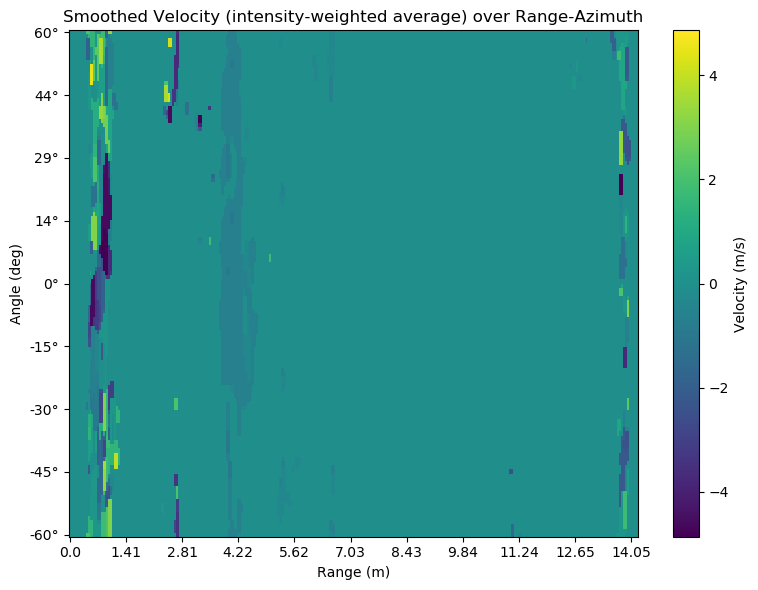

In [36]:
from scipy.ndimage import median_filter

collapsed_doppler = np.argmax(np.abs(radar_cube_windowing), axis=0)
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

# Convert bin indices to velocities
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# ---- Apply Gaussian smoothing ----

sigma = 3  # Smoothing strength — increase for more smoothing
smoothed_velocity = median_filter(collapsed_doppler_velocity, sigma)

# ---- Prepare angle labels ----

angle_bins = radar_cube.shape[1]  # Angle dimension
angles = np.linspace(-60, 60, angle_bins)  # Assuming ±60° FOV over angle_bins

num_ticks = 9  # Number of angle tick marks
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]

# ---- Plot the smoothed velocity map ----

plt.figure(figsize=(8, 6))
im = plt.imshow(smoothed_velocity, aspect='auto', origin='lower', cmap='viridis',
               vmin=-max_doppler,
                vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

plt.yticks(tick_positions, tick_labels)

plt.title('Smoothed Velocity (intensity-weighted average) over Range-Azimuth')
plt.tight_layout()
plt.show()

With weighted average instead of argmax for velocity computation

In [151]:
# Get magnitude over doppler axis
magnitude = np.abs(radar_cube_windowing)  # Shape: [doppler_bins, angle_bins, range_bins]

# Create an array of doppler bin indices (shape [doppler_bins, 1, 1] so it can broadcast)
doppler_indices = np.arange(magnitude.shape[0])[:, np.newaxis, np.newaxis]

# Compute weighted sum of indices
weighted_sum = np.sum(magnitude * doppler_indices, axis=0)

# Compute total intensity per range-azimuth bin
total_intensity = np.sum(magnitude, axis=0) + 1e-6  # Add epsilon to avoid divide by zero

# Weighted average index
velocity_windowing_weighted_av = weighted_sum / total_intensity  # Shape: [angle_bins, range_bins]

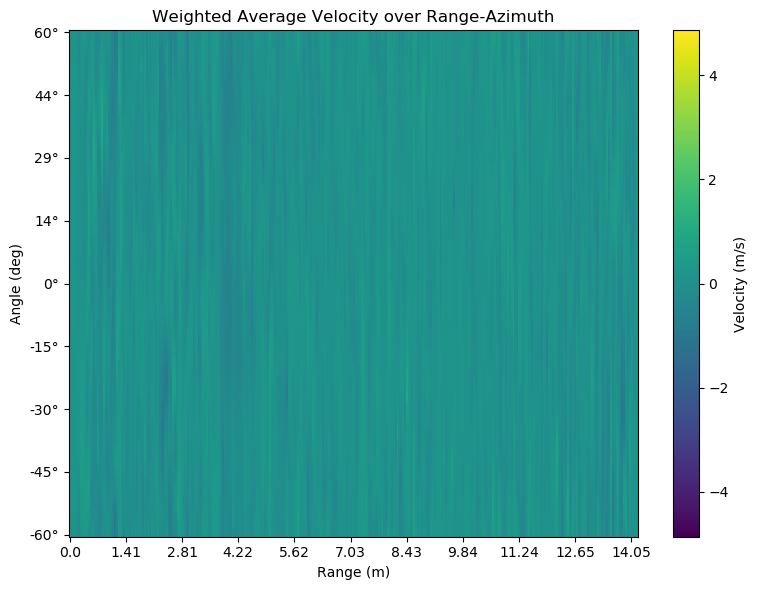

In [157]:
# --- Apply FFTs with windowing ---
window = np.hanning(current_radar_frame.shape[2])  # Range window
window = window[np.newaxis, np.newaxis, :]
range_fft = np.fft.fft(current_radar_frame * window, axis=2)

window = np.hanning(current_radar_frame.shape[0])  # Doppler window
window = window[:, np.newaxis, np.newaxis]
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft * window, axis=0), axes=0)

padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')

window = np.hanning(padded_range_fft.shape[1])  # Azimuth window
window = window[np.newaxis, :, np.newaxis]
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft * window, axis=1), axes=1)

radar_cube_windowing = azimuth_fft  # Final cube shape: [doppler, angle, range]

# --- Compute Doppler-weighted average velocity per pixel ---
magnitude = np.abs(radar_cube_windowing)  # [doppler, angle, range]

doppler_bins = magnitude.shape[0]
doppler_indices = np.arange(doppler_bins)[:, np.newaxis, np.newaxis]  # Shape: [doppler, 1, 1]

# Weighted sum of Doppler indices
weighted_sum = np.sum(magnitude * doppler_indices, axis=0)  # [angle, range]
total_intensity = np.sum(magnitude, axis=0) + 1e-6  # Avoid divide by zero

# Compute weighted Doppler bin index per pixel
weighted_avg_index = weighted_sum / total_intensity  # [angle, range]

# Map Doppler index to physical velocity using interpolation
dopplers = np.linspace(-max_doppler, max_doppler, doppler_bins)  # Should match actual FFT bins
velocity_weighted_avg = np.interp(weighted_avg_index, np.arange(doppler_bins), dopplers)

# --- Plotting ---
plt.figure(figsize=(8, 6))
im = plt.imshow(velocity_weighted_avg, aspect='auto', origin='lower', cmap='viridis',
               vmin=-max_doppler,
               vmax=max_doppler,
               )

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Azimuth ticks
angle_bins = radar_cube.shape[1]
angles = np.linspace(-60, 60, angle_bins)
tick_positions = np.linspace(0, angle_bins - 1, 9)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Weighted Average Velocity over Range-Azimuth')
plt.tight_layout()
plt.show()


We have the same argmax implementation but now with median filtering and thresholding

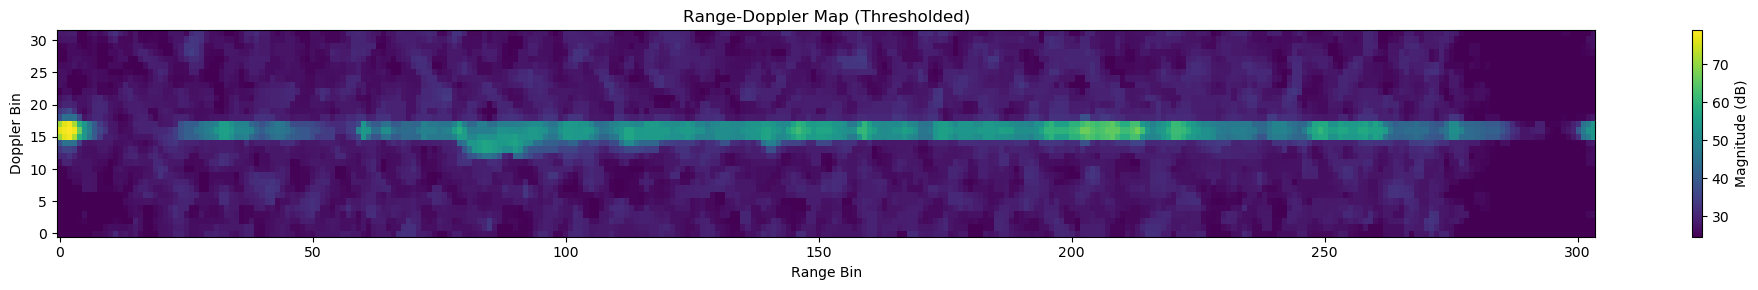

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# --- FFT PROCESSING ---

# Range FFT
window = np.hanning(current_radar_frame.shape[2])
window = window[np.newaxis, np.newaxis, :]
range_fft = np.fft.fft(current_radar_frame * window, axis=2)

# Doppler FFT
window = np.hanning(current_radar_frame.shape[0])
window = window[:, np.newaxis, np.newaxis]
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft * window, axis=0), axes=0)

# Azimuth FFT
padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
window = np.hanning(padded_range_fft.shape[1])
window = window[np.newaxis, :, np.newaxis]
azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft * window, axis=1), axes=1)

radar_cube_windowing = azimuth_fft

# --- POST-PROCESSING ---

# Collapse azimuth → get Range-Doppler (mean over azimuth)
collapsed_range_doppler = np.mean(20 * np.log10(np.abs(radar_cube_windowing) + 1e-12), axis=1)

# Threshold: Clip background below a dynamic floor (e.g., max - 60 dB)
threshold_db = collapsed_range_doppler.max() - 60
collapsed_range_doppler = np.clip(collapsed_range_doppler, a_min=threshold_db, a_max=None)

# Median filter to suppress speckle noise
collapsed_range_doppler = median_filter(collapsed_range_doppler, size=(3, 3))  # You can try (5, 5) too

# --- PLOTTING ---

plt.figure(figsize=(20, 3))
plt.imshow(
    collapsed_range_doppler,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    vmin=threshold_db,  # Avoid plotting clipped background
    vmax=collapsed_range_doppler.max()
)
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Range Bin')
plt.ylabel('Doppler Bin')
plt.title('Range-Doppler Map (Thresholded)')
plt.tight_layout()
plt.show()


We then collapse over doppler to get the velocities

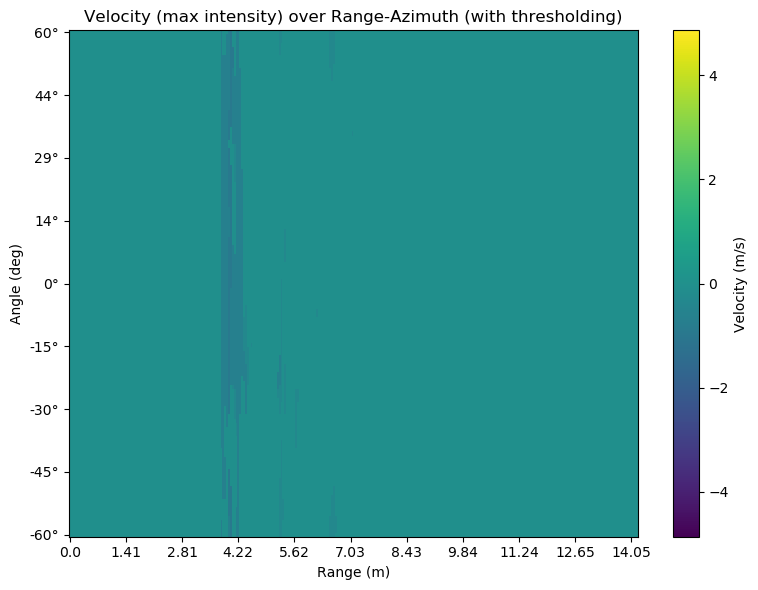

In [178]:
from scipy.ndimage import median_filter

# Step 1: Compute magnitude in dB
magnitude_db = 20 * np.log10(np.abs(radar_cube_windowing) + 1e-12)

# Step 3: Find max Doppler bin index for each azimuth-range pair
collapsed_doppler = np.argmax(magnitude_db, axis=0)  # shape: (azimuth, range)

# Step 4: Compute total intensity at max bin (for thresholding)
max_magnitude_linear = np.max(np.abs(radar_cube_windowing), axis=0)  # shape: (azimuth, range)

# Step 5: Thresholding — set weak points to center bin (index 16)
min_intensity_dB = magnitude_db.max() - 50
min_intensity_linear = 10**(min_intensity_dB / 20)
collapsed_doppler[max_magnitude_linear < min_intensity_linear] = 16  # Assign center bin for weak detections

# Median filter to suppress speckle noise
# collapsed_doppler = median_filter(collapsed_doppler, size=(3, 3))  # You can try (5, 5) too

# Step 6: Map Doppler bin index to velocity values
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# Step 7: Plotting
plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis', vmin = -max_doppler, vmax = max_doppler)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Y-axis: Azimuth angle labels
angle_bins = radar_cube.shape[1]
angles = np.linspace(-60, 60, angle_bins)
num_ticks = 9
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth (with thresholding)')
plt.tight_layout()
plt.show()


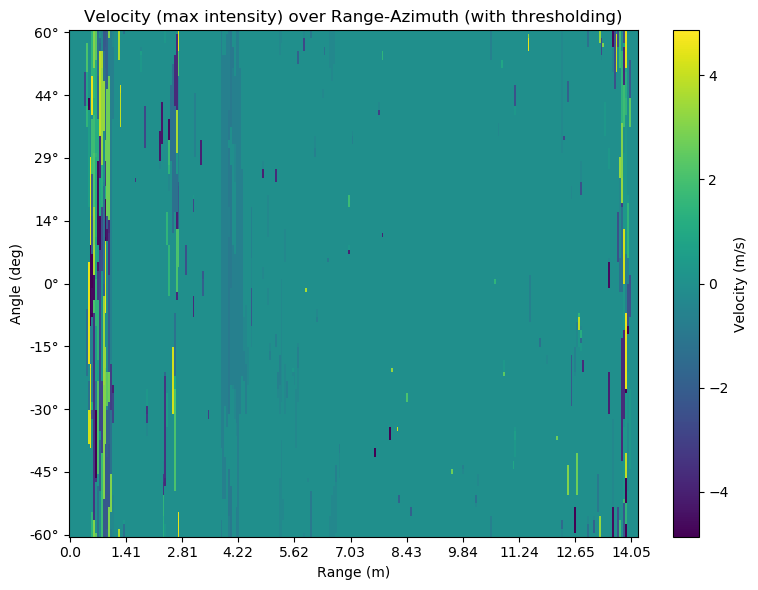

In [139]:
from scipy.ndimage import median_filter

# Step 1: Compute magnitude in dB
magnitude_db = 20 * np.log10(np.abs(radar_cube_windowing) + 1e-12)

# Step 3: Find max Doppler bin index for each azimuth-range pair
collapsed_doppler = np.argmax(magnitude_db, axis=0)  # shape: (azimuth, range)

# Median filter
# collapsed_doppler = median_filter(collapsed_doppler, 3)

# Step 6: Map Doppler bin index to velocity values
dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)
collapsed_doppler_velocity = dopplers[collapsed_doppler]

# Step 7: Plotting
plt.figure(figsize=(8, 6))
im = plt.imshow(collapsed_doppler_velocity, aspect='auto', origin='lower', cmap='viridis', vmin = -max_doppler, vmax = max_doppler)

plt.xticks(range_ticks, range_tick_labels)
plt.xlabel('Range (m)')
plt.ylabel('Angle (deg)')

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label('Velocity (m/s)')

# Y-axis: Azimuth angle labels
angle_bins = radar_cube.shape[1]
angles = np.linspace(-60, 60, angle_bins)
num_ticks = 9
tick_positions = np.linspace(0, angle_bins - 1, num_ticks)
tick_labels = [f"{int(angles[int(pos)])}°" for pos in tick_positions]
plt.yticks(tick_positions, tick_labels)

plt.title('Velocity (max intensity) over Range-Azimuth (with thresholding)')
plt.tight_layout()
plt.show()


1. Windowing introduces noise to the velocity plot
2. Median filter does not help (because it is no longer salt-pepper noise)
3. Thresholding saves the day instead

## 7. Videos

In [37]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt

# output_folder = "radar_frames"
# os.makedirs(output_folder, exist_ok=True)

# for frame_idx in range(data['radar'].shape[0]):

#     # --- RADAR PROCESSING ---

#     # Load radar frame
#     current_radar_frame = data['radar'][frame_idx]
#     rf = RadarFrame(radar_config)

#     # Range FFT
#     range_fft = np.fft.fft(current_radar_frame, axis=2)

#     # Doppler FFT
#     doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=0), axes=0)

#     # Angle FFT
#     padded_range_fft = np.pad(doppler_fft, pad_width=[(0, 0), (0, 112), (0, 0)], mode='constant')
#     azimuth_fft = np.fft.fftshift(np.fft.fft(padded_range_fft, axis=1), axes=1)

#     radar_cube = azimuth_fft

#     # --- COLLAPSE TO VELOCITY ---

#     collapsed_range_doppler = np.argmax(np.abs(radar_cube), axis=0)

#     dopplers = np.arange(-max_doppler, max_doppler + doppler_resolution, doppler_resolution)

#     # Convert bin indices to velocities
#     collapsed_range_doppler_velocity = dopplers[collapsed_range_doppler]

#     # --- COLLAPSE TO POWER (dB) ---

#     collapsed_range_doppler_db = np.mean(20 * np.log10(np.abs(radar_cube) + 1e-6), axis=0)  # Avoid log(0)

#     # --- PLOTTING ---

#     fig, axs = plt.subplots(1, 3, figsize=(18, 6))

#     # 1️. Radar velocity plot
#     im0 = axs[0].imshow(collapsed_range_doppler_velocity, 
#                         aspect='auto', 
#                         origin='lower', 
#                         cmap='viridis',
#                         vmin=-max_doppler, 
#                         vmax=max_doppler + doppler_resolution)

#     axs[0].set_xticks(range_ticks)
#     axs[0].set_xticklabels(range_tick_labels)
#     axs[0].set_xlabel('Range (m)')
#     axs[0].set_ylabel('Angle (deg)')
#     axs[0].set_title('Velocity (max intensity)')

#     cbar = plt.colorbar(im0, ax=axs[0])
#     cbar.set_label('Velocity (m/s)')

#     # 2️. RGB image plot
#     axs[1].imshow(data['rgb'][frame_idx][..., ::-1])  # Assuming RGB is BGR
#     axs[1].axis('off')
#     axs[1].set_title('RGB Image')

#     # 3. Power map (dB)
#     im2 = axs[2].imshow(collapsed_range_doppler_db,
#                         aspect='auto',
#                         origin='lower',
#                         cmap='plasma')

#     axs[2].set_xticks(range_ticks)
#     axs[2].set_xticklabels(range_tick_labels)
#     axs[2].set_xlabel('Range (m)')
#     axs[2].set_ylabel('Angle (deg)')
#     axs[2].set_title('Mean Power (dB)')

#     # No colorbar as you requested

#     plt.suptitle(f'Frame {frame_idx}', fontsize=16)
#     plt.tight_layout()

#     # Save the figure
#     filename = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
#     plt.savefig(filename)
#     plt.close()  # Close the figure to save memory


In [38]:
# !ffmpeg -r 5 -i radar_frames/frame_%04d.png -vcodec libx264 -pix_fmt yuv420p radar_video.mp4

To do: 

- Change angle calculation with the correct scaling ($sin^{-1}$)
- Scale all data to correct units with equations from slides
- Change velocity estimation to weighted average 